# Geo Experimentation via Time Based Regression in PyMC

## Prepare Notebook

In [1]:
import arviz as az
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
from itertools import chain


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Read Data

In [2]:
data_df = pd.read_csv("../data/zipcodes_data.csv", parse_dates=["date"])

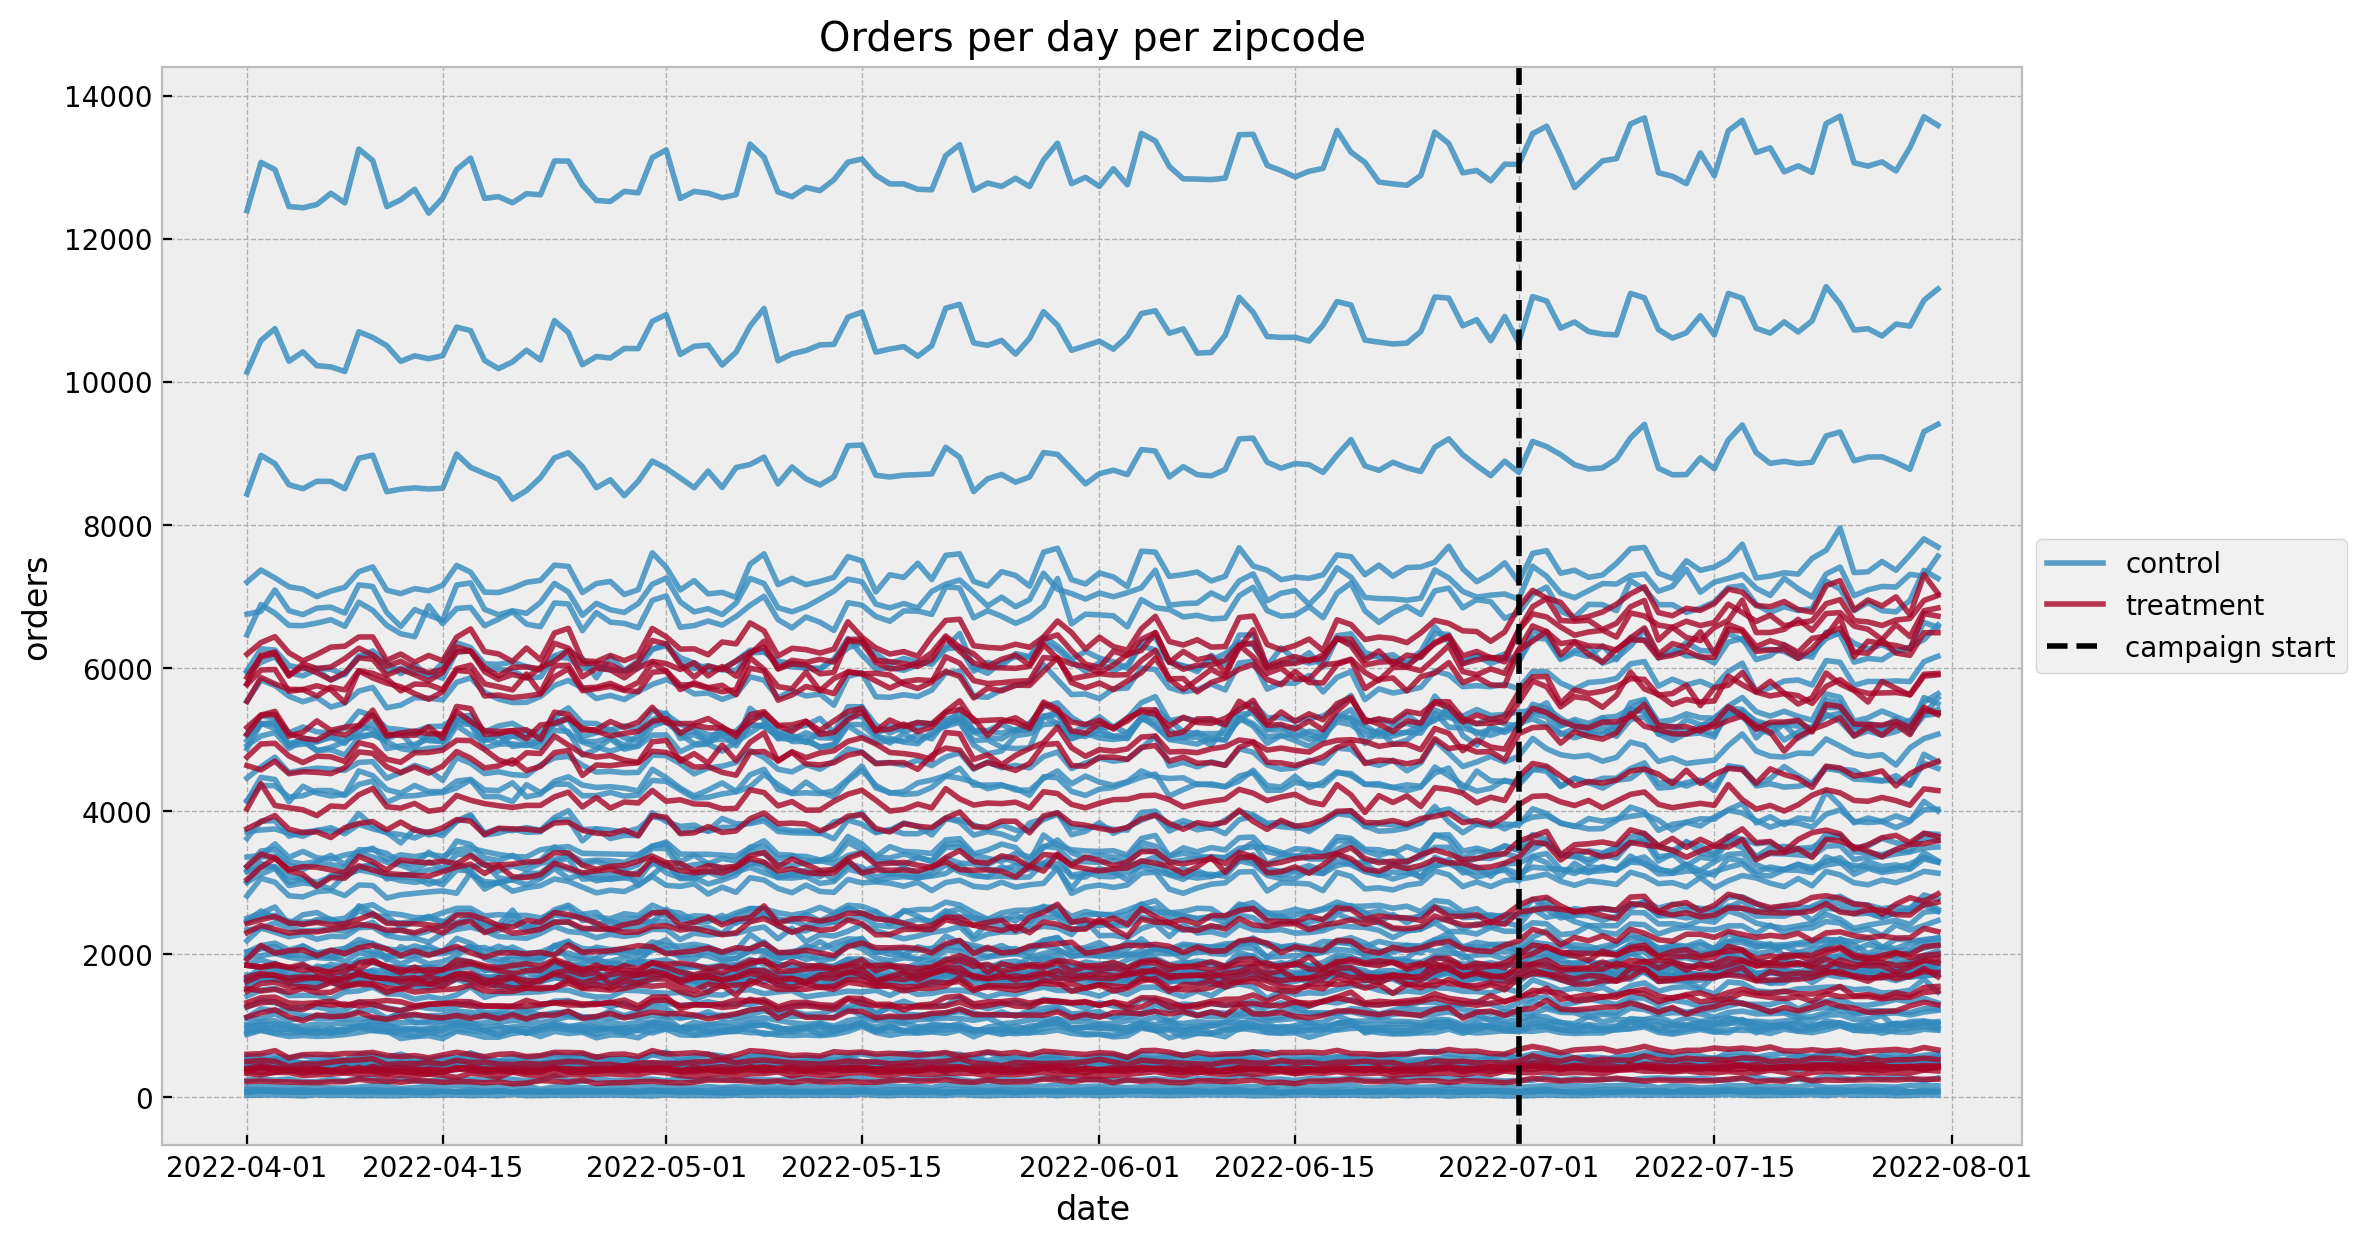

In [3]:
start_campaign = datetime(2022, 7, 1)

fig, ax = plt.subplots(figsize=(12, 7))

for i, variant in enumerate(["control", "treatment"]):
    for j, (_, df) in enumerate(
        data_df.query("variant == @variant").groupby("zipcode")
    ):
        label = variant if j == 0 else None
        sns.lineplot(
            x="date", y="orders", data=df, color=f"C{i}", alpha=0.8, label=label, ax=ax
        )

ax.axvline(x=start_campaign, color="black", linestyle="--", label="campaign start")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Orders per day per zipcode", xlabel="date", ylabel="orders");

## Prepare Data

In [4]:
agg_data_df = (
    data_df
    .groupby(["date", "is_campaign", "variant"], as_index=False)
    .agg({"orders": np.sum})
)

data_train = (
    agg_data_df
    .query("~ is_campaign")
    .pivot(index="date", columns="variant", values="orders")
    .reset_index()
)

data_test = (
    agg_data_df
    .query("is_campaign")
    .pivot(index="date", columns="variant", values="orders")
    .reset_index()
)

In [5]:
date_train = data_train["date"].to_numpy()
y_control_train = data_train["control"].to_numpy()
y_treatment_train = data_train["treatment"].to_numpy()

date_test = data_test["date"].to_numpy()
y_control_test = data_test["control"].to_numpy()
y_treatment_test = data_test["treatment"].to_numpy()

n_train = data_train.shape[0]
n_test = data_test.shape[0]
n = n_train + n_test
idx_train = range(n_train)
idx_test = range(n_train, n)

# weighted linear regression: https://discourse.pymc.io/t/how-to-add-weights-to-data-in-bayesian-linear-regression/8362
w_train = np.linspace(start=0.8, stop=1, num=n_train)
w_train = np.ones(shape=n_train)
w_test = np.ones(shape=n_test)

In [6]:
scaler_control = StandardScaler()
scaler_treatment = StandardScaler()

scaler_control.fit(X=y_control_train[..., None])
scaler_treatment.fit(X=y_treatment_train[..., None])

y_control_train_scaled = scaler_control.transform(X=y_control_train[..., None]).flatten()
y_treatment_train_scaled = scaler_treatment.transform(X=y_treatment_train[..., None]).flatten()

y_control_test_scaled = scaler_control.transform(X=y_control_test[..., None]).flatten()
y_treatment_test_scaled = scaler_treatment.transform(X=y_treatment_test[..., None]).flatten()

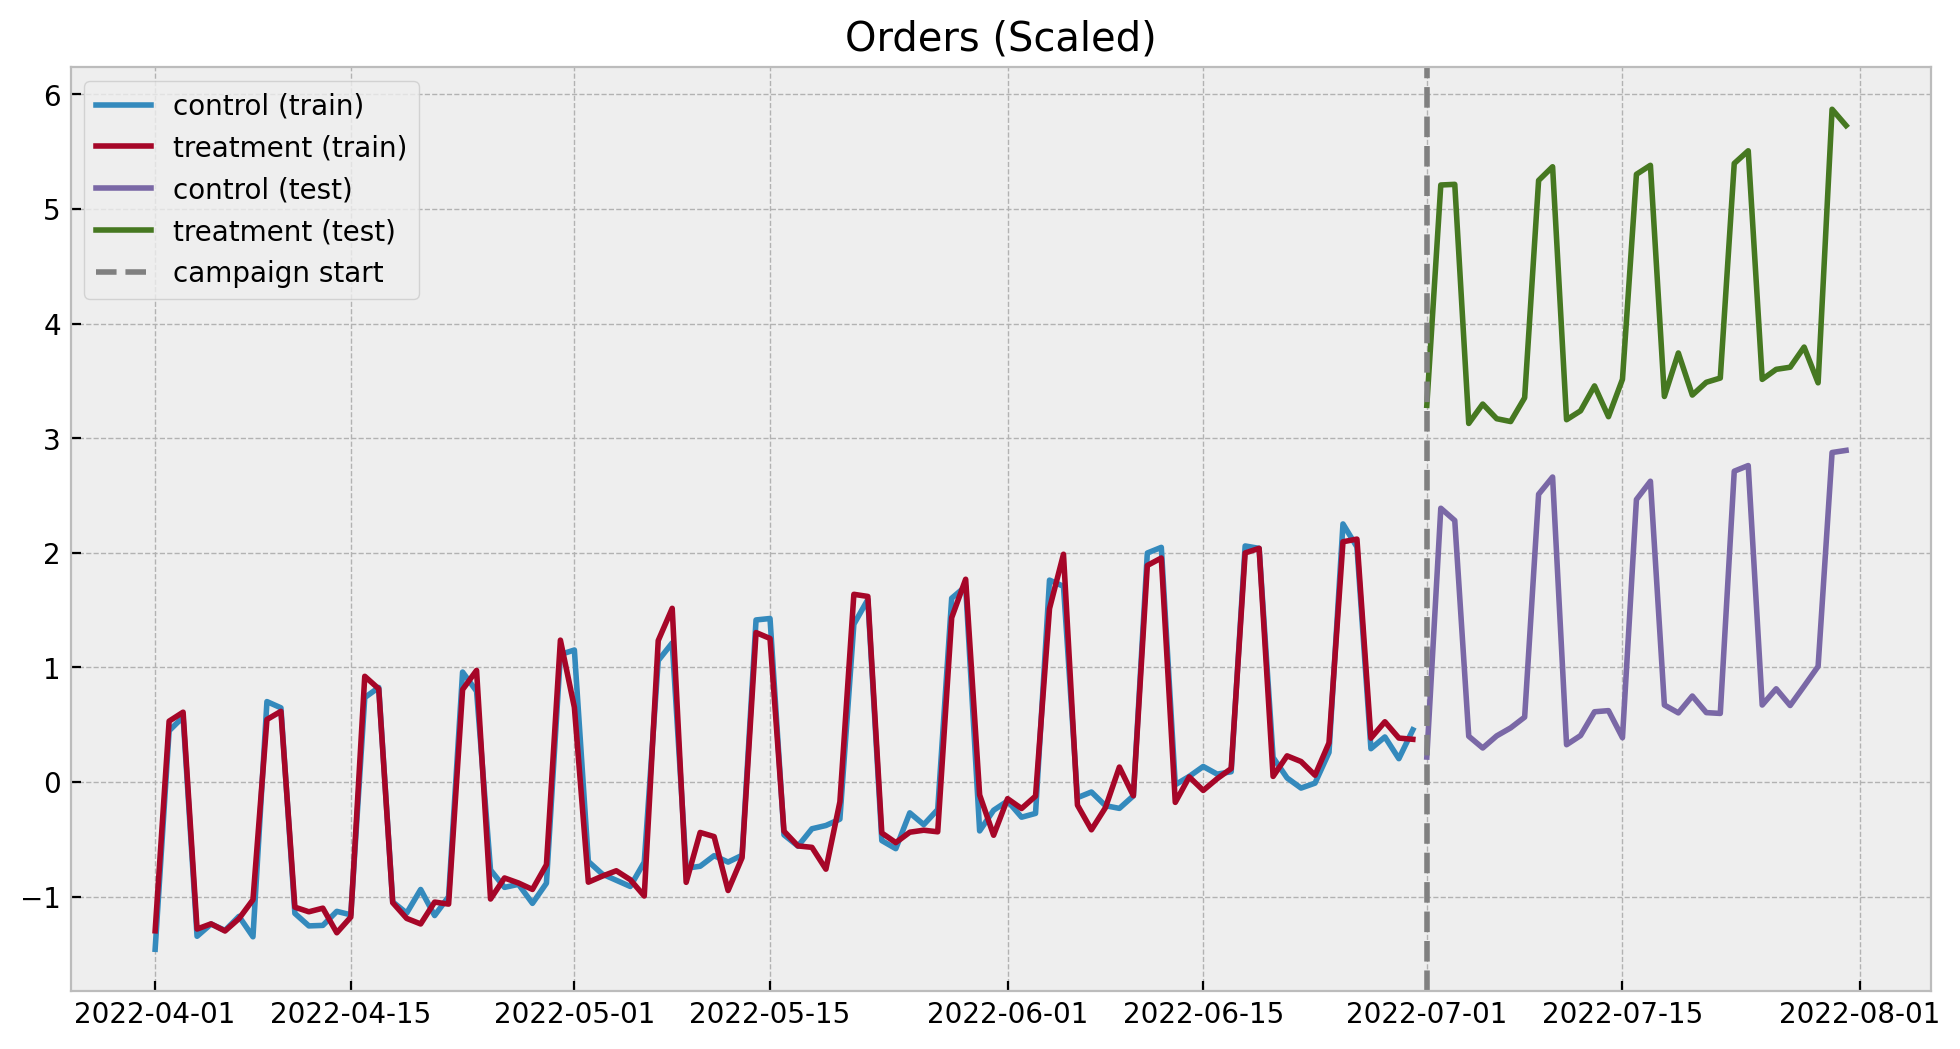

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    x=date_train, y=y_control_train_scaled, color="C0", label="control (train)", ax=ax
)
sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    color="C1",
    label="treatment (train)",
    ax=ax,
)
sns.lineplot(
    x=date_test, y=y_control_test_scaled, color="C2", label="control (test)", ax=ax
)
sns.lineplot(
    x=date_test,
    y=y_treatment_test_scaled,
    color="C3",
    label="treatment (test)",
    ax=ax,
)
ax.axvline(x=start_campaign, color="gray", linestyle="--", label="campaign start")
ax.legend(loc="upper left")
ax.set(title="Orders (Scaled)");

## Define Model

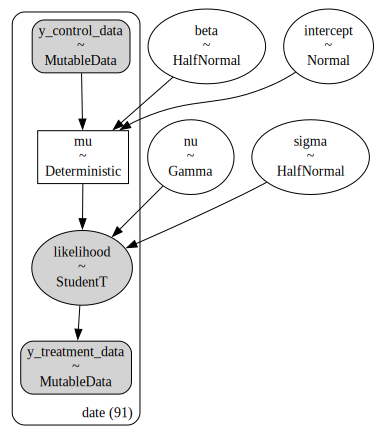

In [8]:
with pm.Model() as model:
    # --- Data Containers ---
    model.add_coord(name="date", values=date_train, mutable=True)
    y_control_data = pm.MutableData(
        name="y_control_data", value=y_control_train_scaled, dims="date"
    )
    y_treatment_data = pm.MutableData(
        name="y_treatment_data", value=y_treatment_train_scaled, dims="date"
    )
    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    beta = pm.HalfNormal(name="beta", sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)
    nu = pm.Gamma(name="nu", alpha=20, beta=2)
    # --- Model Parametrization ---
    mu = pm.Deterministic(name="mu", var=intercept + beta * y_control_data, dims="date")
    # --- Likelihood ---
    likelihood = pm.StudentT(
        "likelihood", mu=mu, nu=nu, sigma=sigma, observed=y_treatment_data, dims="date"
    )

pm.model_to_graphviz(model=model)

## Prior Predictive Check

In [9]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1000)

Sampling: [beta, intercept, likelihood, nu, sigma]
INFO:pymc:Sampling: [beta, intercept, likelihood, nu, sigma]


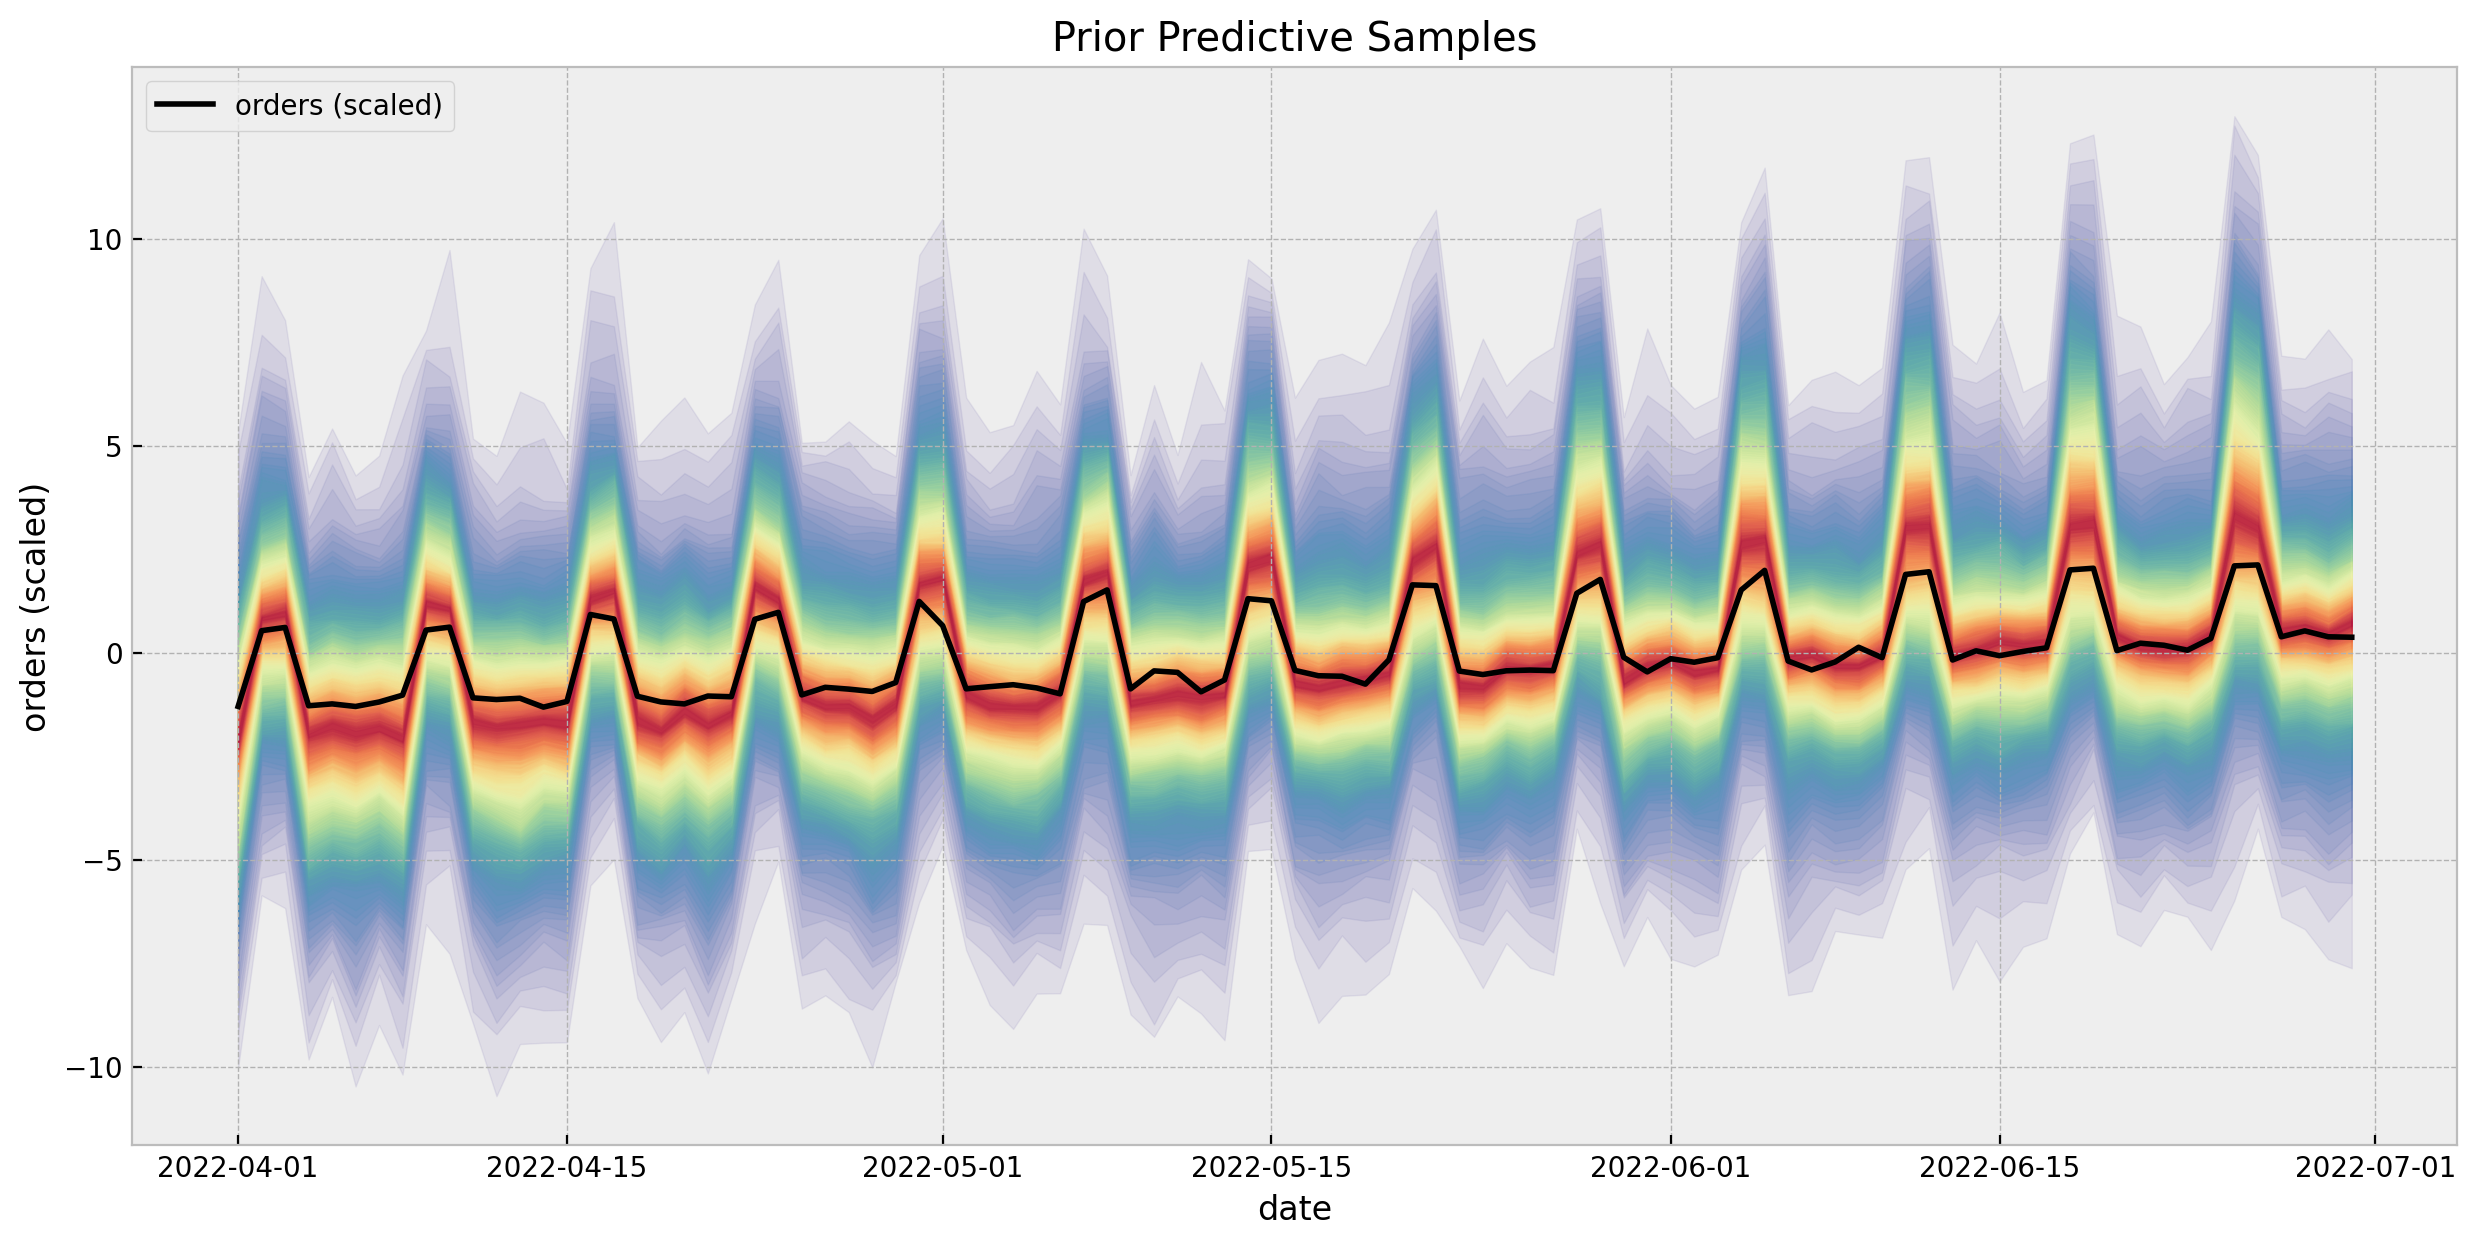

In [10]:
palette = "Spectral_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date_train,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    label="orders (scaled)",
    color="black",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title=f"Prior Predictive Samples",
    xlabel="date",
    ylabel=f"orders (scaled)",
);

## Fit Model

In [11]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=5000, chains=4)
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:02.513021
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:04.378410
Transforming variables...
Transformation time =  0:00:00.171492
Computing Log Likelihood...


Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


Log Likelihood time =  0:00:01.005521


## Model Diagnostics

In [12]:
var_names = [
    "intercept",
    "beta",
    "sigma",
    "nu",
]

In [13]:
az.summary(data=idata, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept   0.003  0.018  -0.031    0.037      0.000    0.000   21067.0   
beta        0.985  0.018   0.951    1.018      0.000    0.000   21638.0   
sigma       0.157  0.014   0.132    0.183      0.000    0.000   18429.0   
nu         10.368  2.215   6.347   14.508      0.016    0.011   19777.0   

           ess_tail  r_hat  
intercept   13757.0    1.0  
beta        15262.0    1.0  
sigma       15595.0    1.0  
nu          15154.0    1.0

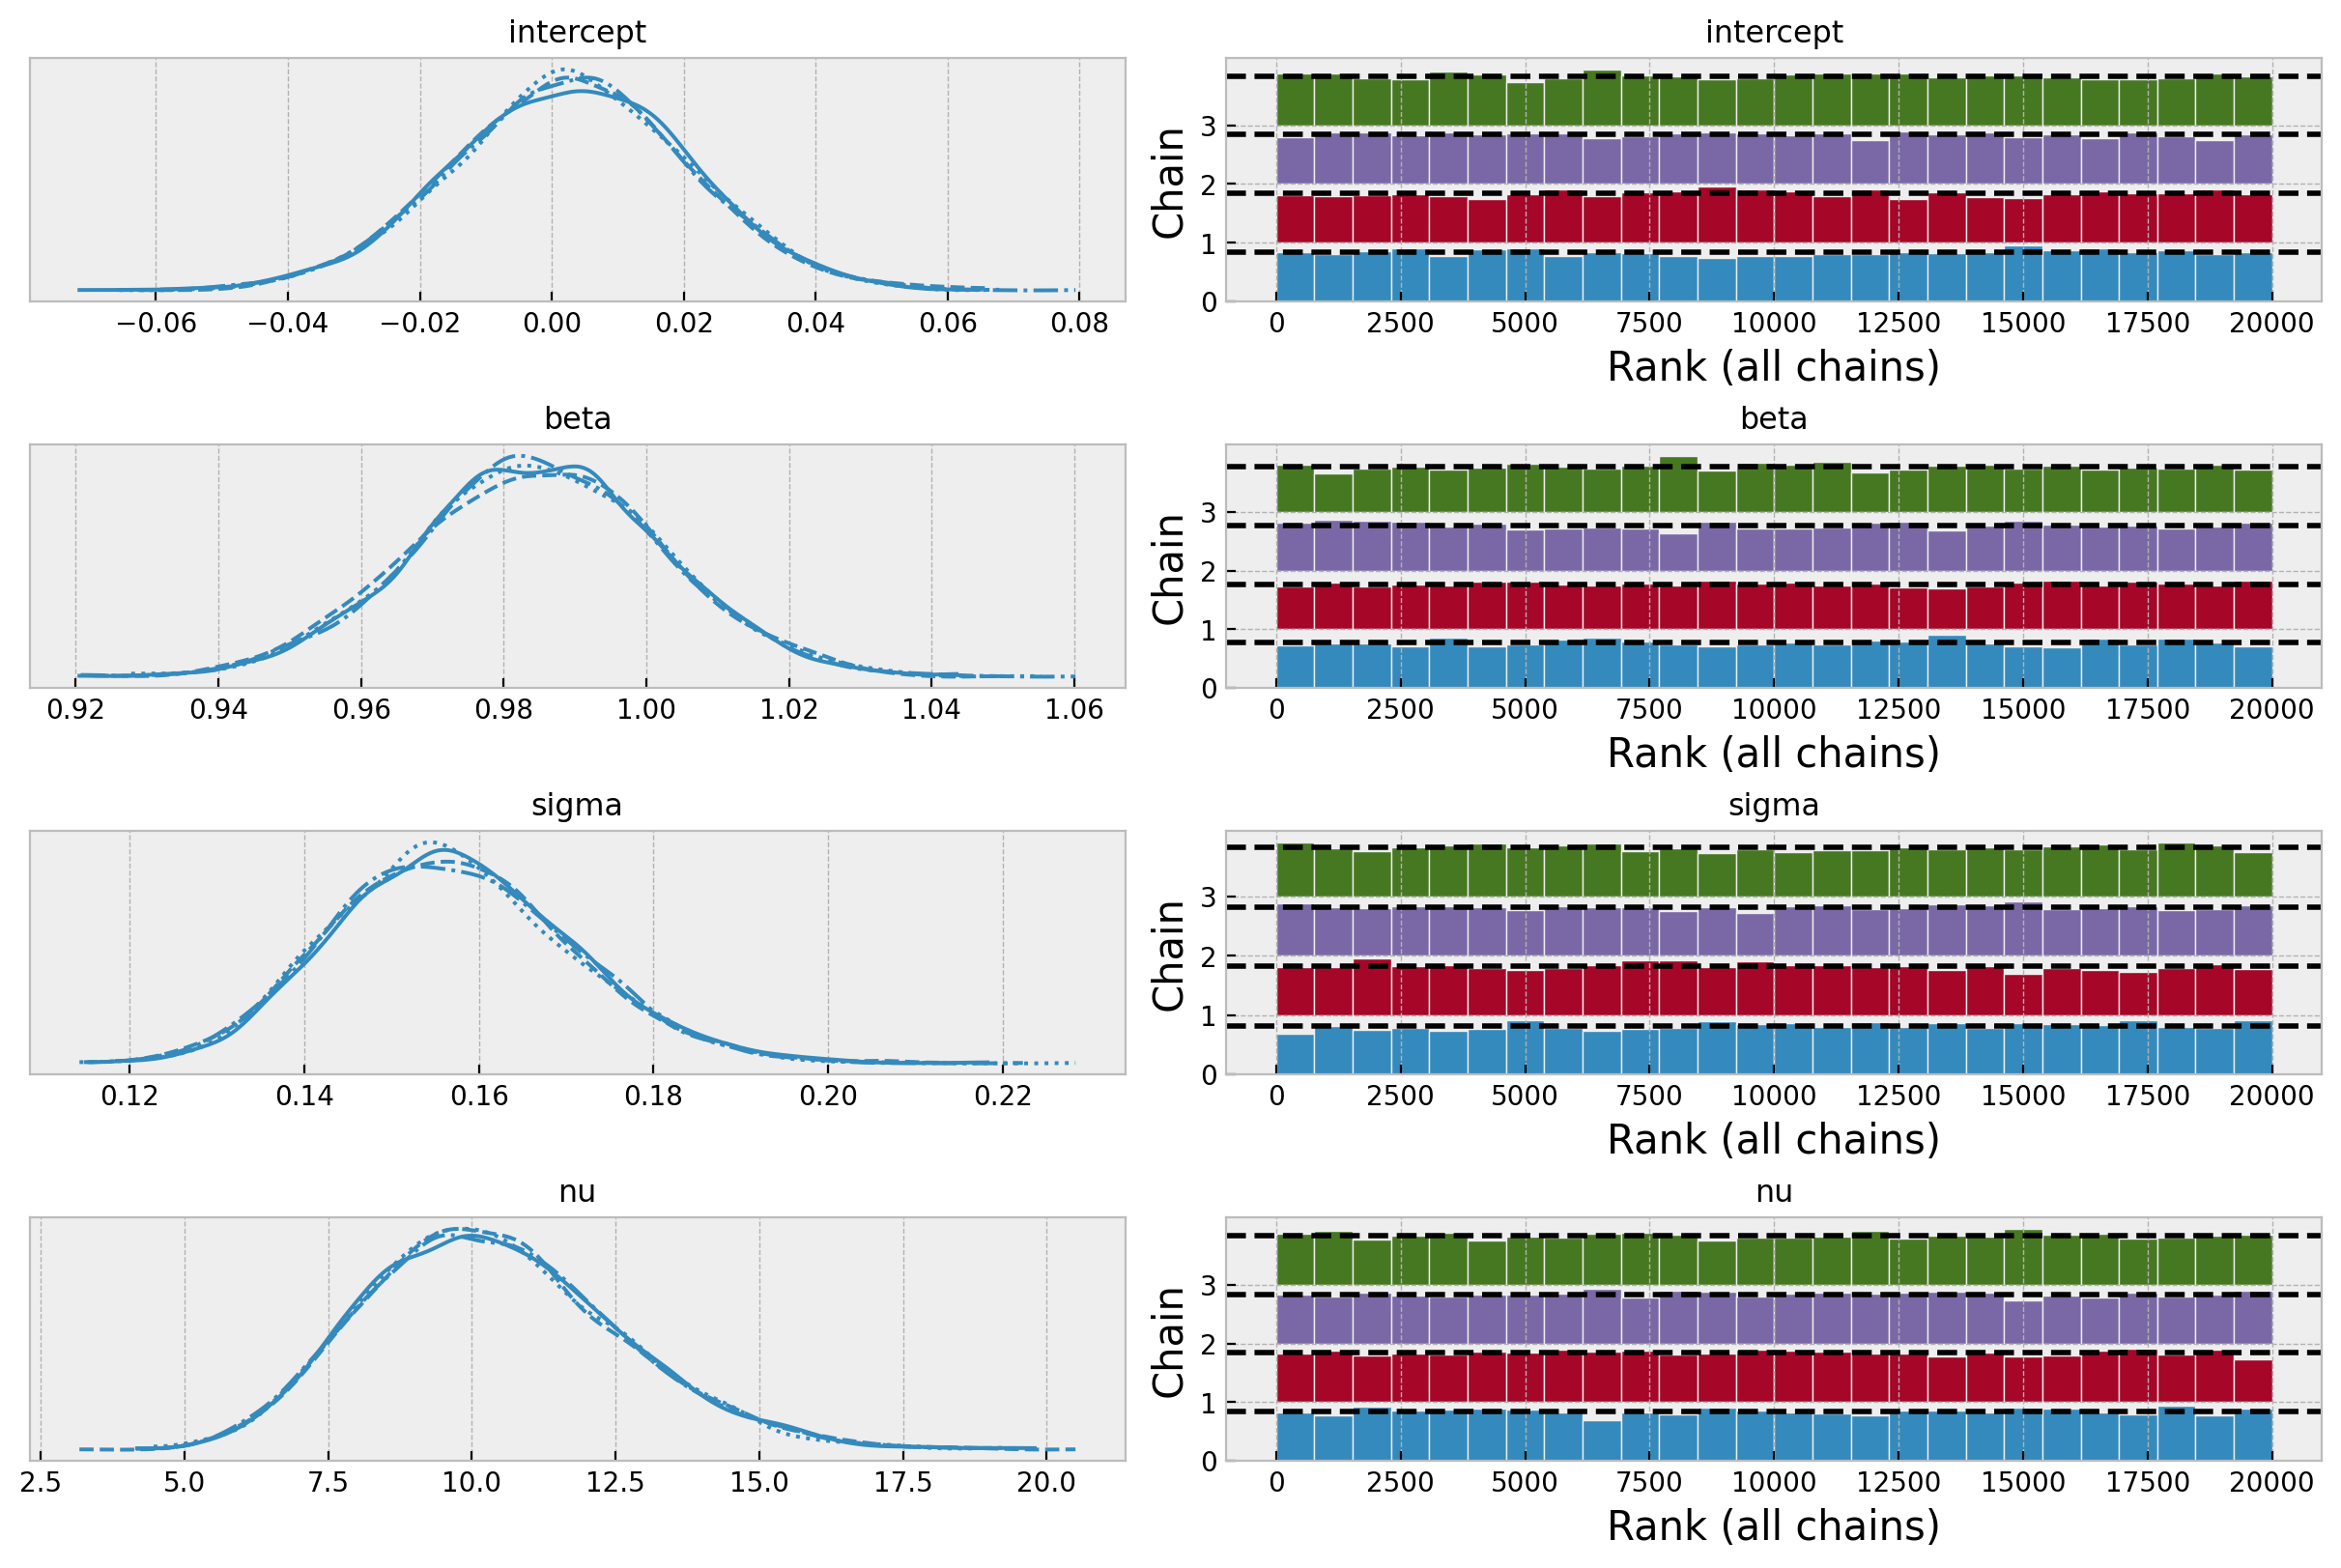

In [14]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)

## Posterior Predictive (Train)

[Text(0.5, 1.0, 'Posterior Predictive Samples (Train)- Orders (Scaled)'),
 Text(0.5, 0, 'date'),
 Text(0, 0.5, 'orders (scaled)')]

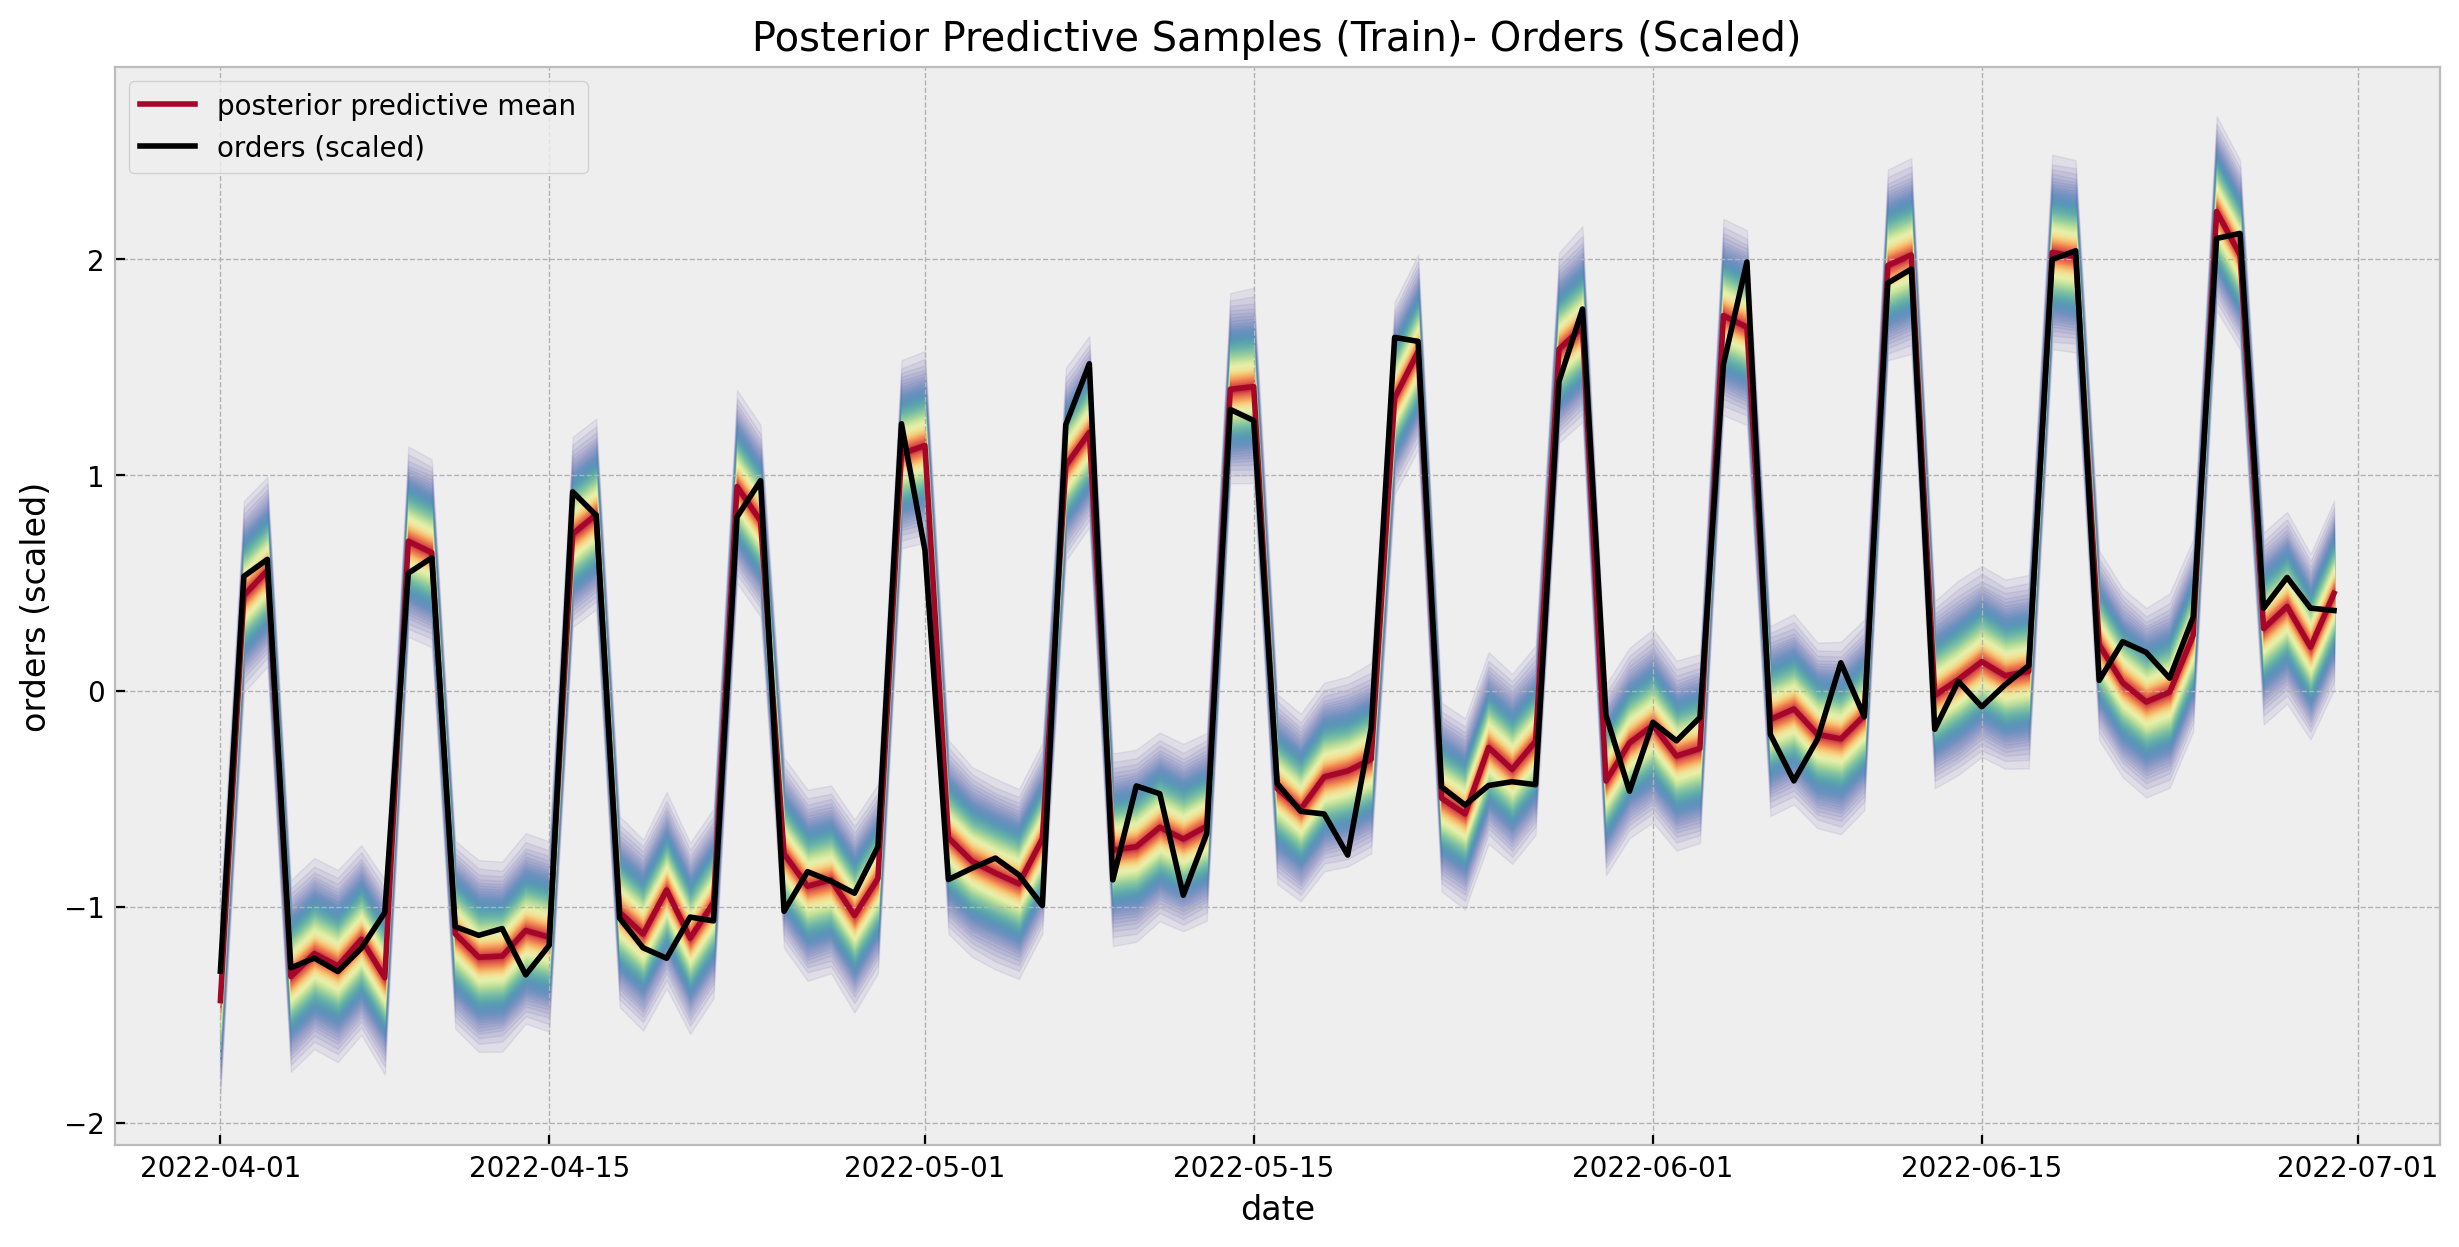

In [15]:
posterior_predictive_likelihood_train = az.extract(data=posterior_predictive, group="posterior_predictive", var_names=["likelihood"])

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_train, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_train, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date_train,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_train,
    y=posterior_predictive_likelihood_train.mean(axis=1),
    color="C1",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    color="black",
    label="orders (scaled)",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title=f"Posterior Predictive Samples (Train)- Orders (Scaled)",
    xlabel="date",
    ylabel=f"orders (scaled)",
)

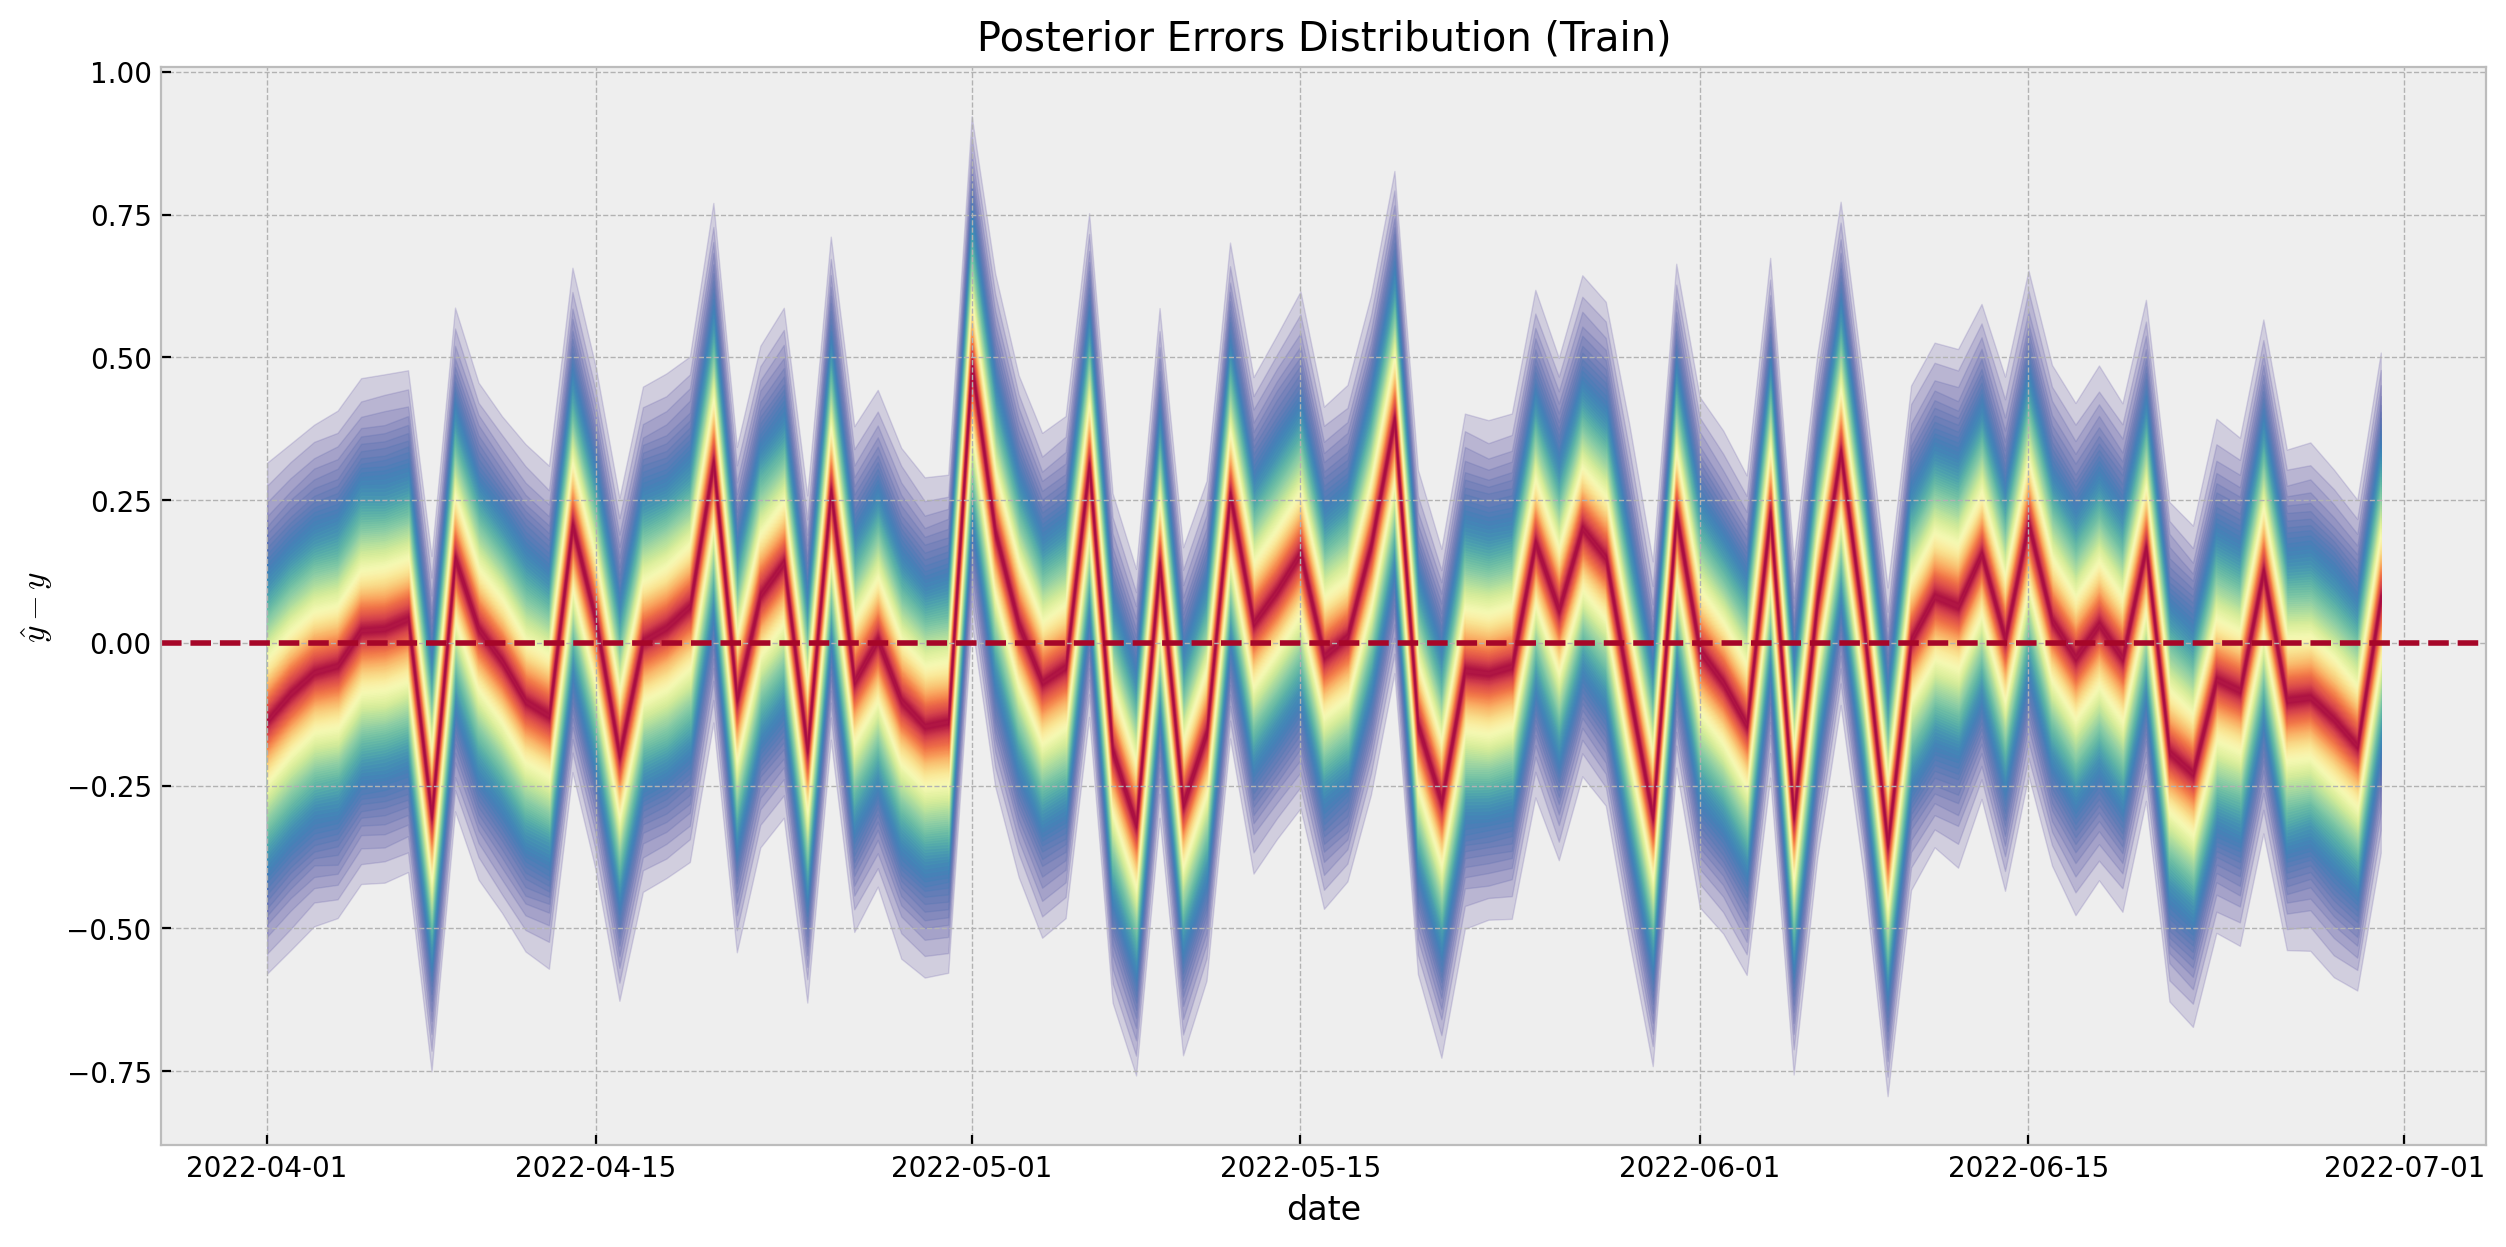

In [16]:
errors_train = (
    posterior_predictive_likelihood_train - y_treatment_train_scaled[..., None]
)

errors_train_inv = (
    scaler_treatment.inverse_transform(X=posterior_predictive_likelihood_train)
    - y_treatment_train[..., None]
)

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(a=errors_train, q=p, axis=1)
    lower = np.percentile(a=errors_train, q=100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_train, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.axhline(y=0, color="C1", linestyle="--")
ax.set(
    title="Posterior Errors Distribution (Train)",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
);

## Uncertainty Quantification

## Posterior Predictive (Test)

In [17]:
with model:
    pm.set_data(
        new_data={
            "y_control_data": y_control_test_scaled,
            "y_treatment_data": y_treatment_test_scaled,
        },
        coords={"date": date_test},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["likelihood", "mu"],
            idata_kwargs={"coords": {"date": date_test}},
        )
    )

Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


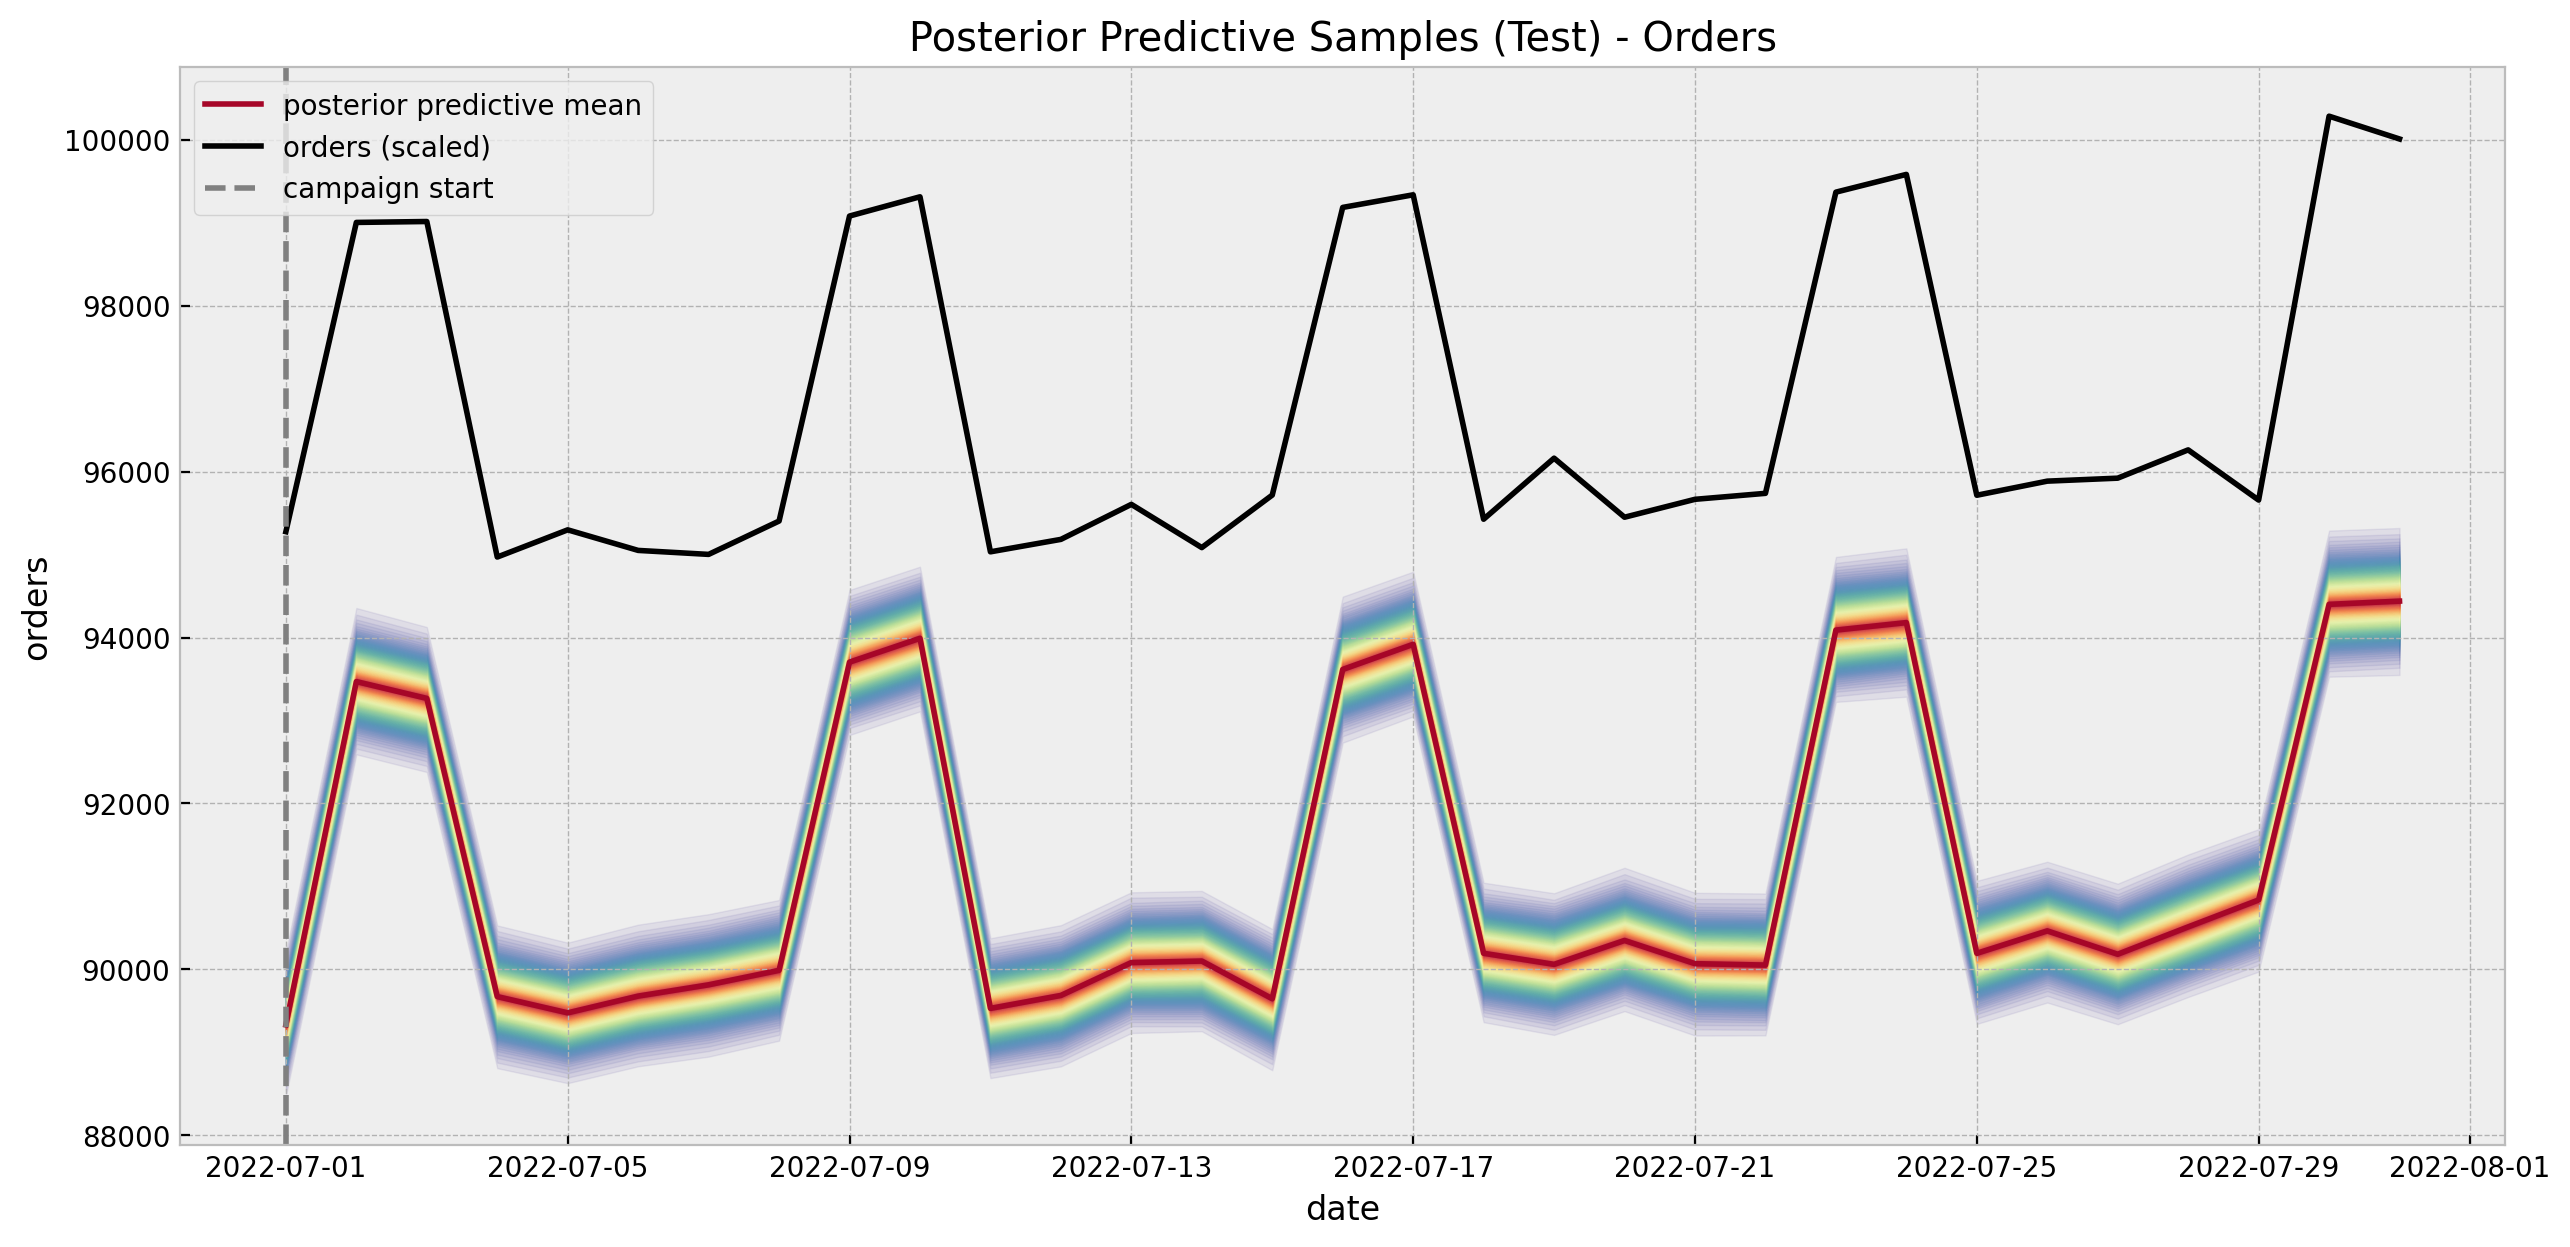

In [18]:
posterior_predictive_likelihood_test = az.extract(
    data=idata, group="posterior_predictive", var_names=["likelihood"]
)

posterior_predictive_likelihood_test_inv = scaler_treatment.inverse_transform(
    X=posterior_predictive_likelihood_test
)

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(a=posterior_predictive_likelihood_test_inv, q=p, axis=1)
    lower = np.percentile(a=posterior_predictive_likelihood_test_inv, q=100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date_test,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_test,
    y=posterior_predictive_likelihood_test_inv.mean(axis=1),
    color="C1",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date_test,
    y=y_treatment_test,
    color="black",
    label="orders (scaled)",
    ax=ax,
)
ax.axvline(x=start_campaign, color="gray", linestyle="--", label="campaign start")
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive Samples (Test) - Orders",
    xlabel="date",
    ylabel="orders",
);

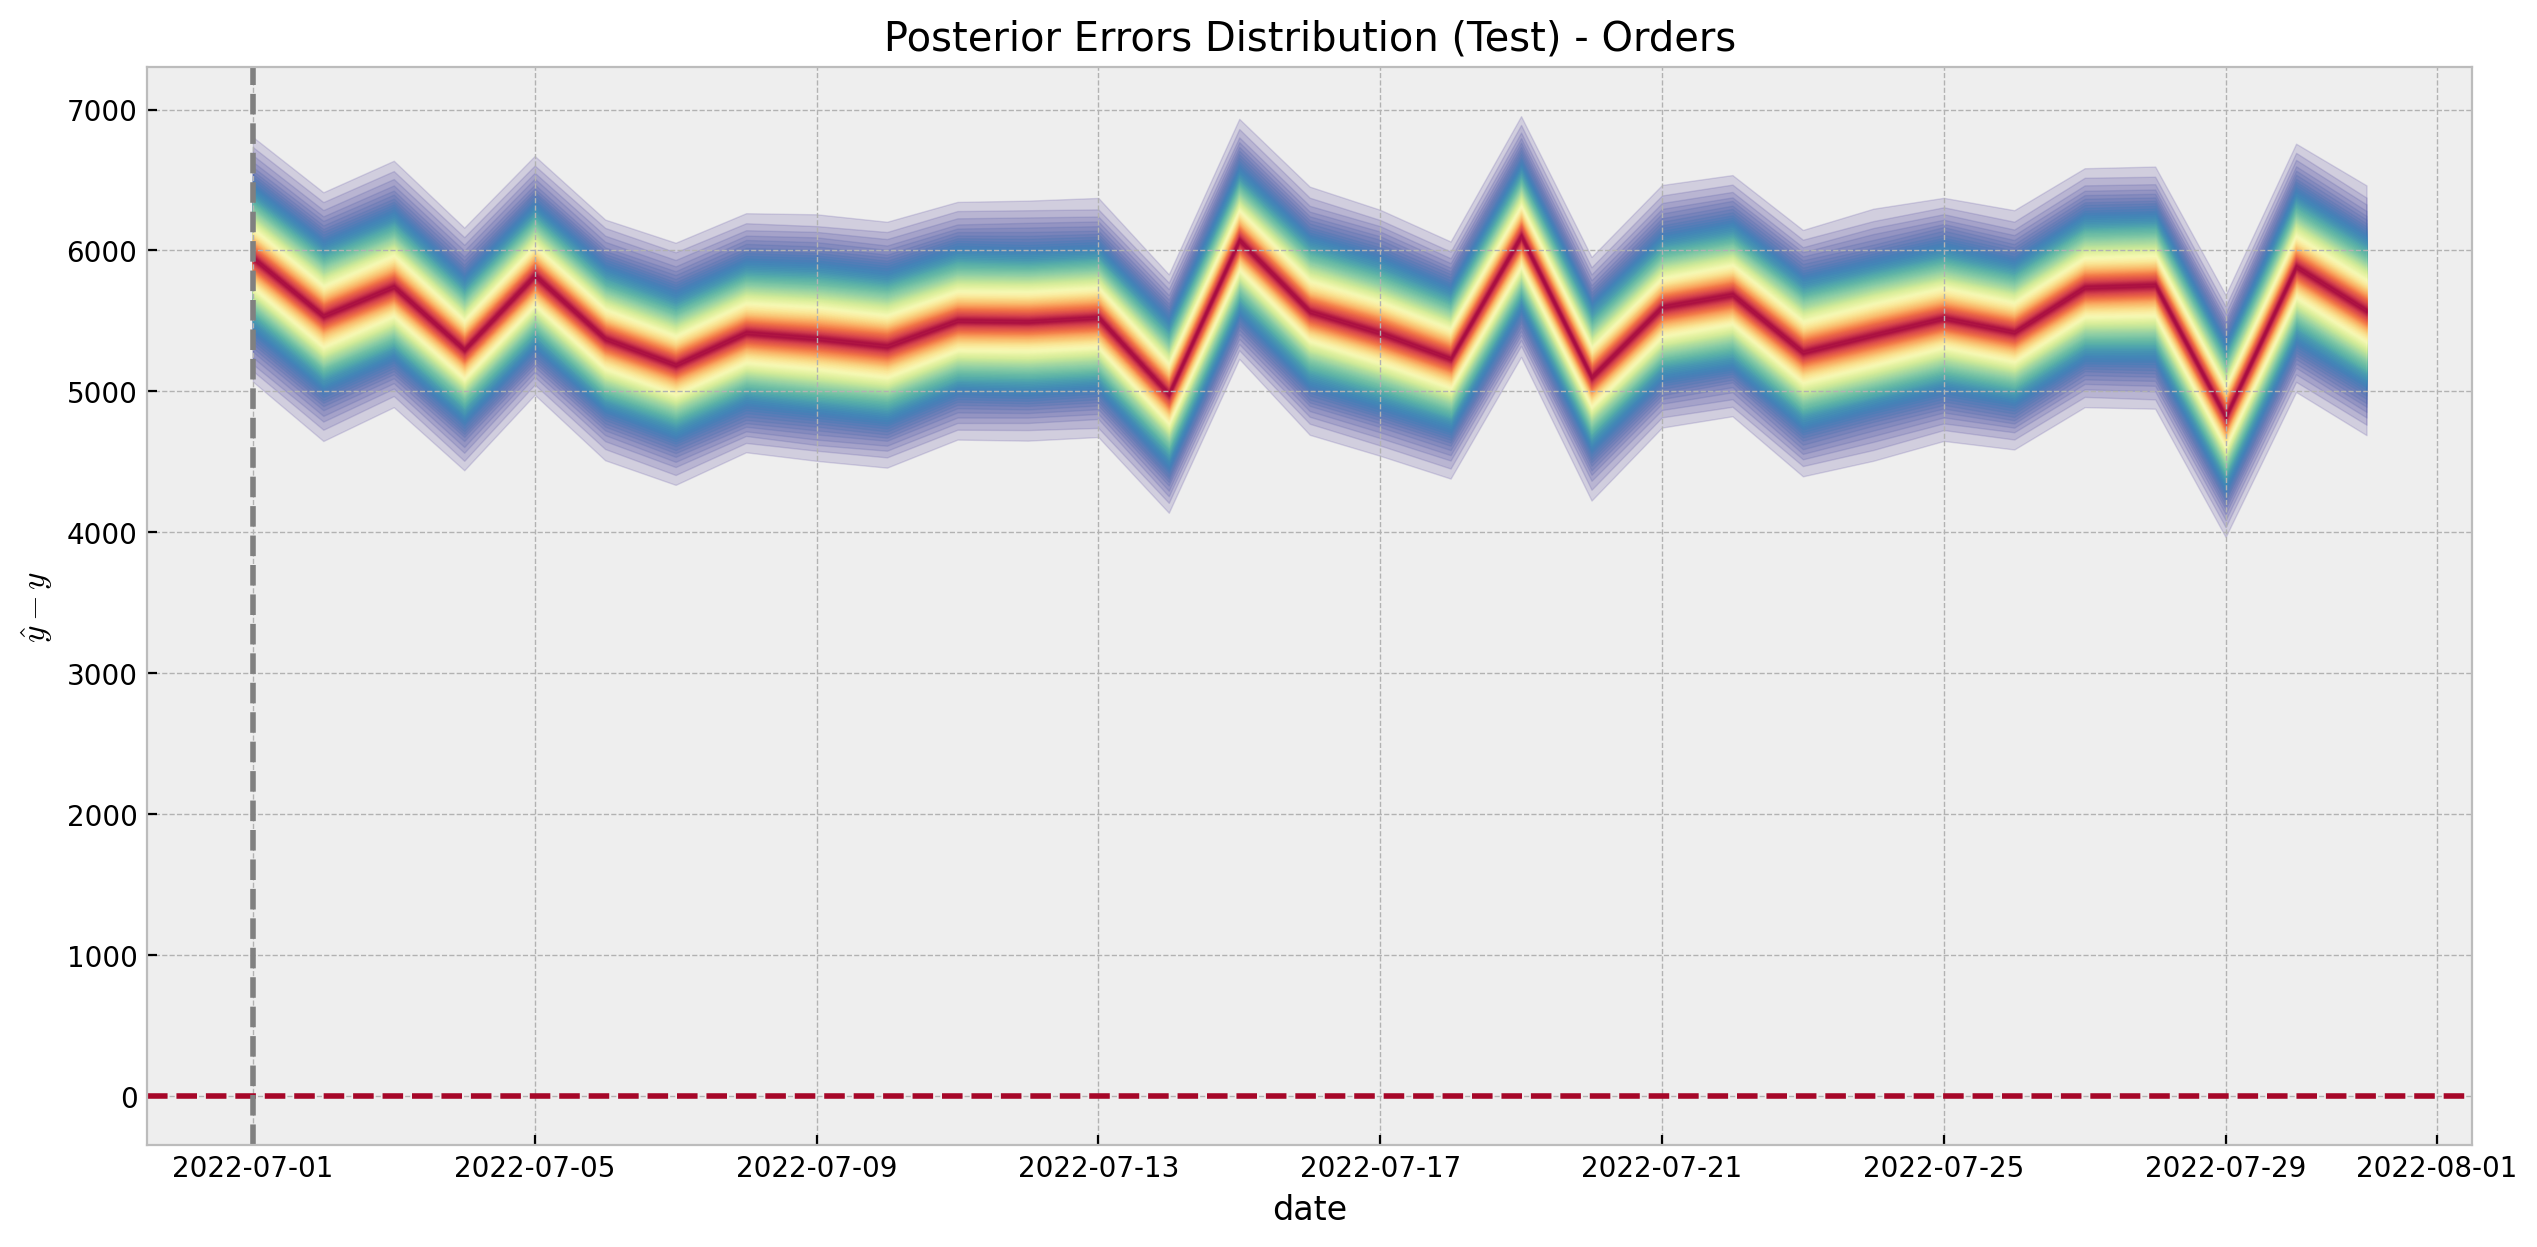

In [19]:
errors_test_inv = y_treatment_test[..., None] - posterior_predictive_likelihood_test_inv


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(a=errors_test_inv, q=p, axis=1)
    lower = np.percentile(a=errors_test_inv, q=100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_test, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.axhline(y=0, color="C1", linestyle="--")
ax.axvline(x=start_campaign, color="gray", linestyle="--", label="campaign start")
ax.set(
    title="Posterior Errors Distribution (Test) - Orders",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
);

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_29103/2028730792.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  errors_test_cumsum_hdi = az.hdi(ary=errors_test_cumsum.T)[-1, :]


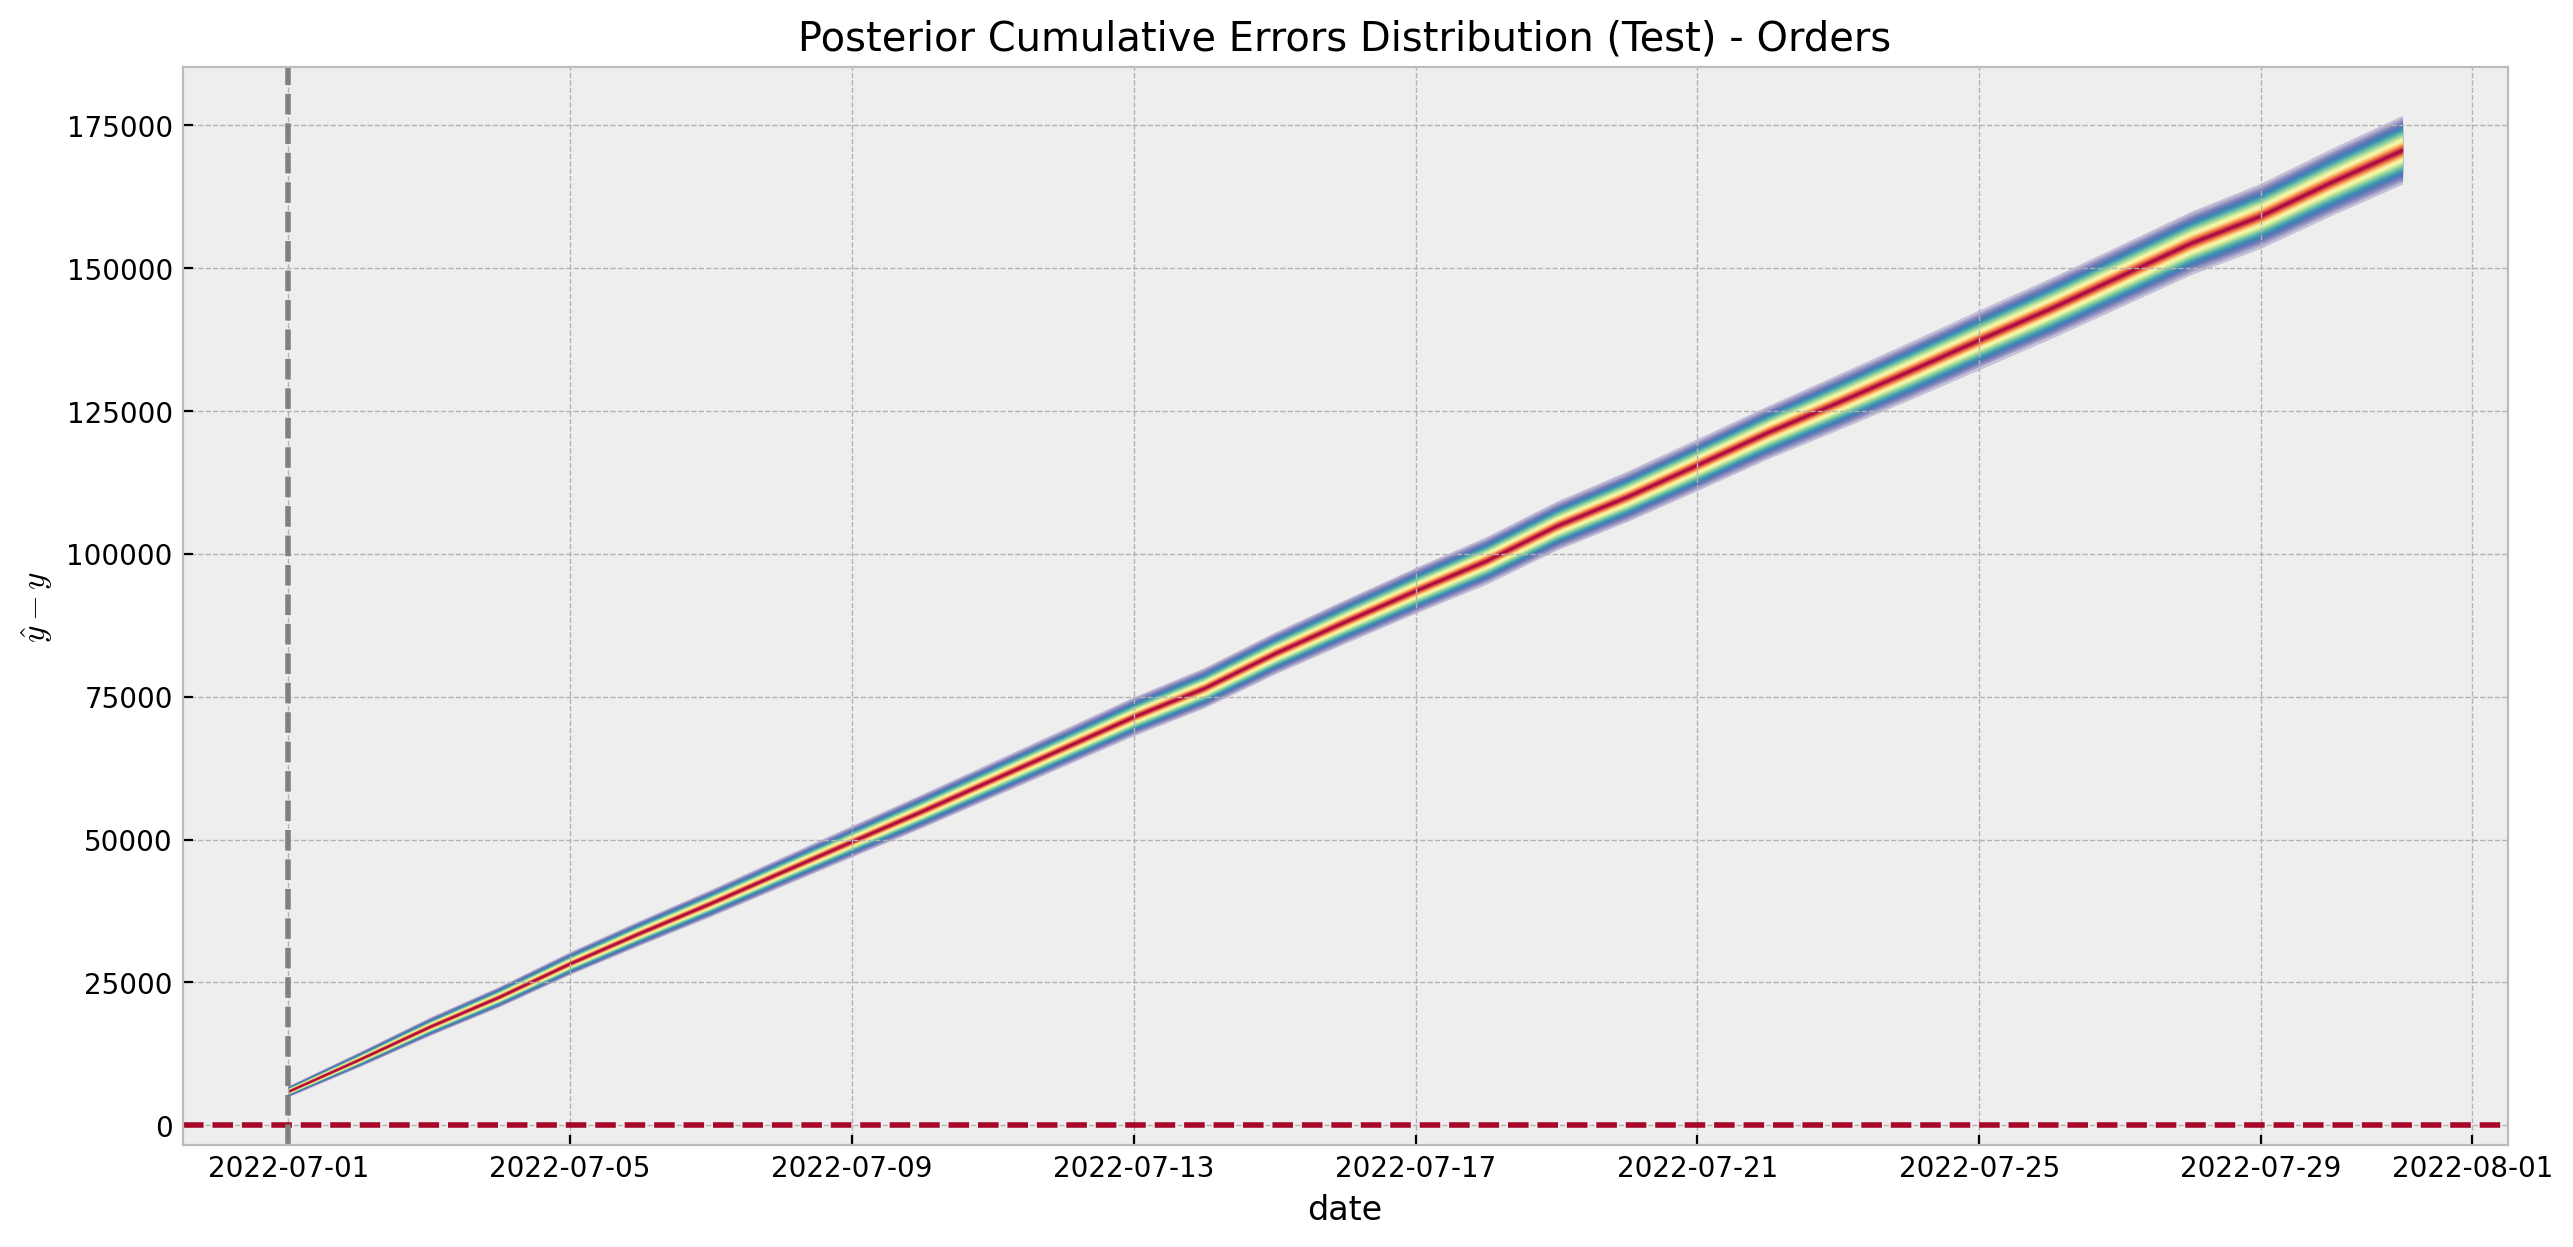

In [20]:
errors_test_cumsum = errors_test_inv.cumsum(axis=0)
errors_test_cumsum_hdi = az.hdi(ary=errors_test_cumsum.T)[-1, :]


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(a=errors_test_cumsum, q=p, axis=1)
    lower = np.percentile(a=errors_test_cumsum, q=100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_test, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.axhline(y=0, color="C1", linestyle="--")
ax.axvline(x=start_campaign, color="gray", linestyle="--", label="campaign start")
ax.set(
    title="Posterior Cumulative Errors Distribution (Test) - Orders",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
);